In [1]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]

df = pd.read_csv('housing.csv', usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)

In [3]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [4]:
features = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "ocean_proximity"]


train_dicts = df_train[features].to_dict(orient='records')
val_dicts = df_val[features].to_dict(orient='records')

In [5]:
from sklearn.feature_extraction import DictVectorizer

In [6]:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

## Question 1

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [8]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [9]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



C:\Users\gh611680\Anaconda3\envs\DSdigi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Question 2

In [10]:
from sklearn.ensemble import RandomForestRegressor

In [11]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [12]:
from sklearn.metrics import mean_squared_error

In [13]:
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

0.2457383433183843

## Question 3

In [14]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

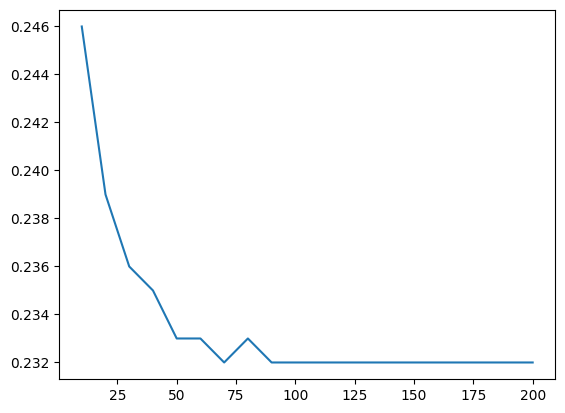

In [15]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

In [16]:
scores = []

rf = RandomForestRegressor(n_estimators=0,
                           random_state=1, n_jobs=-1,
                           warm_start=True)

for n in tqdm(range(10, 201, 10)):
    rf.n_estimators = n
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

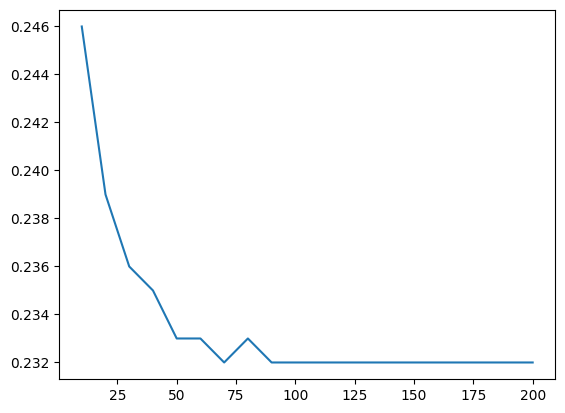

In [17]:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

## Question 4

In [18]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

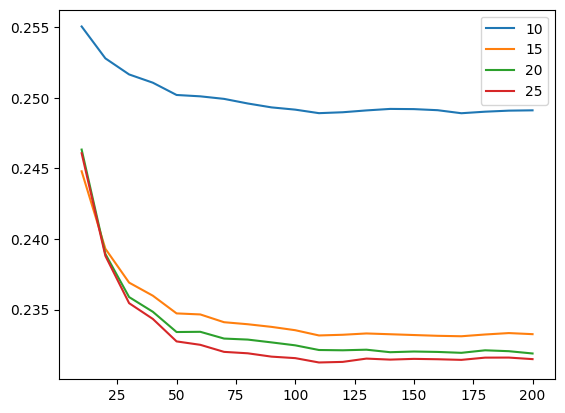

In [19]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()

## Question 5

In [20]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, 
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [21]:
rf.feature_importances_

array([1.69573183e-02, 3.30938997e-02, 1.01333971e-01, 9.62649876e-02,
       3.62912907e-01, 3.00723750e-03, 3.10900842e-01, 3.56806263e-04,
       4.48661972e-04, 4.22762446e-03, 3.09180197e-02, 1.90412562e-02,
       2.05364687e-02])

In [22]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names()
df_importances['importance'] = rf.feature_importances_
df_importances

C:\Users\gh611680\Anaconda3\envs\DSdigi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,importance
0,households,0.016957
1,housing_median_age,0.033094
2,latitude,0.101334
3,longitude,0.096265
4,median_income,0.362913
5,ocean_proximity=<1H OCEAN,0.003007
6,ocean_proximity=INLAND,0.310901
7,ocean_proximity=ISLAND,0.000357
8,ocean_proximity=NEAR BAY,0.000449
9,ocean_proximity=NEAR OCEAN,0.004228


In [23]:
df_importances.sort_values(by='importance', ascending=False).head()

,feature,importance
4,median_income,0.362913
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101334
3,longitude,0.096265
1,housing_median_age,0.033094


## Question 6

In [24]:
import xgboost as xgb

In [25]:
feature = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "ocean_proximity"]

In [26]:
feature

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'ocean_proximity']

In [27]:
features

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'ocean_proximity']

In [28]:
train_dicts

[{'longitude': -118.18,
  'latitude': 34.63,
  'housing_median_age': 19.0,
  'total_rooms': 3562.0,
  'total_bedrooms': 606.0,
  'population': 1677.0,
  'households': 578.0,
  'median_income': 4.1573,
  'ocean_proximity': 'INLAND'},
 {'longitude': -116.9,
  'latitude': 34.69,
  'housing_median_age': 10.0,
  'total_rooms': 337.0,
  'total_bedrooms': 102.0,
  'population': 108.0,
  'households': 50.0,
  'median_income': 0.4999,
  'ocean_proximity': 'INLAND'},
 {'longitude': -118.26,
  'latitude': 33.78,
  'housing_median_age': 27.0,
  'total_rooms': 1672.0,
  'total_bedrooms': 491.0,
  'population': 1723.0,
  'households': 462.0,
  'median_income': 2.0458,
  'ocean_proximity': 'NEAR OCEAN'},
 {'longitude': -117.33,
  'latitude': 34.17,
  'housing_median_age': 5.0,
  'total_rooms': 4718.0,
  'total_bedrooms': 1140.0,
  'population': 2564.0,
  'households': 1056.0,
  'median_income': 2.9877,
  'ocean_proximity': 'INLAND'},
 {'longitude': -119.02,
  'latitude': 35.35,
  'housing_median_age'

In [29]:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [30]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [31]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [32]:
scores = {}

In [38]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 9,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [ ]:
scores['eta=0.1'] = parse_xgb_output(output)

In [45]:
scores['eta=0.1']

,num_iter,train_auc,val_auc
0,0,10.44372,10.44938
1,5,6.17513,6.17987
2,10,3.65739,3.66123
3,15,2.17445,2.17850
4,20,1.30397,1.30884
5,25,0.79456,0.80322
6,30,0.50083,0.51696
7,35,0.33602,0.36513
8,40,0.24684,0.28840
9,45,0.20331,0.25470


In [47]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 9,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=4, evals=watchlist)

In [48]:
parse_xgb_output(output)

,num_iter,train_auc,val_auc
0,0,10.44372,10.44938
1,4,6.85878,6.86368
2,8,4.50846,4.51264
3,12,2.96890,2.97276
4,16,1.96137,1.96526
5,20,1.30397,1.30884
6,24,0.87614,0.88388
7,28,0.59903,0.61148
8,32,0.42288,0.44362
9,36,0.31299,0.34452


(50.0, 100.0)

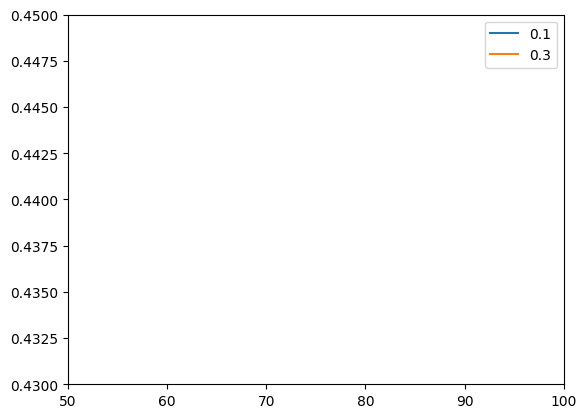

In [49]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()

plt.ylim([0.43, 0.45])
plt.xlim([50, 100])